# Quenching Times and Infall Times

This notebook uses the data generated by the timestep bulk processing (`h148bulk.py`, etc or `timescales_bulk.py`) to calculate infall times and quenching times for all the dwarfs that were at one time a satellite. It saves the resulting calculations to a data file, `QuenchingTimescales_200b.data` because it can take a while to generate the cumulative SFHs for all these galaxies.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
print(mpl.get_backend())
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

module://ipykernel.pylab.backend_inline


## Define some functions

In [6]:
def read_file(path, halo_num):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(path,'rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

def cumulative_sfh(simpath,halo_num):
    age = 13.800797497330507
    s = pynbody.load(simpath)
    s.physical_units()
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar
    
    return c_sfh, age-bincenters

## Run through all halos and calculate quenching time, infall time, and gas loss times

In [245]:
h148 = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096'
h242 = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.004096'
h229 = '/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h229.cosmo50PLK.3072gst5HbwK1BH.004096'
h329 = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h329.cosmo50PLK.3072gst5HbwK1BH.004096'

path = '/home/akinshol/Data/Timescales/DataFiles20190731/'

q_thresh = 0.99
q_lowerlim = 0.98
q_upperlim = 1.

i_thresh = 1
i_upperlim = 0.9
i_lowerlim = 1.1

g_thresh = 0.1
g_lowerlim = 0.05
g_upperlim = 0.15


age = 13.800797497330507

with open('/home/akinshol/Data/Timescales/QuenchingTimescales_200b.data','wb') as f:
    for name,simpath in zip(['h148','h242','h229','h329'],[h148,h242,h229,h329]):
        data = read_file(path+name+'.data','all')
        ids = np.unique(np.array(data.z0haloid,dtype=int))
        
        for i in ids:
            print(f'Running for simulation {name}, halo {i}',end='\t')
            
            current_data = read_file(path+name+'.data', i)
            time = np.array(current_data.time, dtype=float)
            mstar = np.array(current_data.mstar, dtype=float)[0]
            
            sSFR = np.array(current_data['sfr'][time > 13.6])[0] / mstar
            HIratio = np.array(current_data['mHI'][time > 13.6])[0] / mstar
            print(f'sSFR {sSFR}, HI richness {HIratio}')
            
            time = age - time
            
            if sSFR > 1e-11:
                is_quenched = False
            else:
                is_quenched = True
#                 print('Halo unquenched, skipping...')
#                 continue           
            
            # skip if we don't have at least 10 Gyr of data from merger trees
            if np.max(time) < 10:
                print(f'data only goes back {np.max(time):.2f} Gyr, skipping')
                continue
                
            c_sfh, bc = cumulative_sfh(simpath,i)

            dist = np.array(current_data.h1dist, dtype=float)
            gasfrac = np.array(current_data.gasfrac, dtype=float)
            HIratio = np.array(current_data.mHI,dtype=float)/np.array(current_data.mstar, dtype=float)
            mvir = np.array(current_data.mass, dtype=float)[0]
            peak_Pram = np.max(np.array(current_data.Pram, dtype=float))
            peak_Pratio = np.max(np.array(current_data.ratio, dtype=float))
            
            if gasfrac[0] > 0:
                has_gas = True
            else:
                has_gas = False

            # get quenched time
            try:
                tq = np.max(bc[c_sfh >= q_thresh])
                tq_lowerlim = np.max(bc[c_sfh >= q_lowerlim])
                tq_upperlim = np.max(bc[c_sfh >= q_upperlim])
                t90 = np.max(bc[c_sfh >= 0.9])
            except:
                print('Skipping quenching time (check this!)')
                continue

            # get gas loss time
            if not has_gas:
                try:
                    tg = np.max(time[gasfrac < g_thresh])
                    tg_lowerlim = np.max(time[gasfrac < g_lowerlim])
                    tg_upperlim = np.max(time[gasfrac < g_upperlim])
                except ValueError:
                    tg = None
                    tg_lowerlim = None
                    tg_upperlim = None
            else:
                tg = 0
                tg_lowerlim = 0
                tg_upperlim = 0
                print('Has gas at z=0, setting tgas = 0')
                
            # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 0.5:
                    th = t
                    print('Hi gas loss time %.2f' % th)
                    break
                else:
                    th = None
                    
            # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 1:
                    th_lowerlim = t
                    break
                else:
                    th_lowerlim = None
            
                        # get HI gas loss time
            for t, Hi in zip(time, HIratio):
                if Hi > 0.2:
                    th_upperlim = t
                    break
                else:
                    th_upperlim = None

            # remove gas loss / HI gas loss time if there was never any gas
            if (gasfrac == 0.).all():
                tg = None
                th = None

            # get infall time
            try:
                ti = np.max(time[dist <= i_thresh])
                ti_upperlim = np.max(time[dist <= i_upperlim])
                ti_lowerlim = np.max(time[dist <= i_lowerlim])
            except ValueError:
                ti, ti_upperlim, ti_lowerlim = None, None, None

            
            # calculate periapsis and apoapsis
            periapsis = np.min(dist)
            if ti is not None:
                try:
                    dist_after_infall = dist[time < ti-1] # distance values 
                    time_after_infall = time[time < ti-1]

                    apoapsis = np.max(dist_after_infall)
                    apocenter = np.argmax(dist_after_infall)


                    if time_after_infall[apocenter] == np.max(time_after_infall):
                        print('Apoapsis occurs at infall, assuming inaccuracy')
                        apoapsis = None

                    if time_after_infall[apocenter] == np.min(time_after_infall):
                        print('Apoapsis occurs at z = 0, assuming inaccuracy')
                        apoapsis = None

                    if apoapsis is not None:
                        eccentricity = (apoapsis - periapsis) / (apoapsis + periapsis)
                        print(f'eccentricity {eccentricity}')
                    else:
                        eccentricity = None
                except:
                    print('Uncaught error in eccentricity calculation')
                    apoapsis, eccentricity = None, None
            else:
                apoapsis, periapsis, eccentricity = None, None, None


            print(f'tquench = {tq}, tinfall = {ti}')

            
            pickle.dump({
                'haloid':i,
                'quenched':is_quenched,
                'has_gas':has_gas,
                'tquench':tq,
                'tquench_lower':tq_lowerlim,
                'tquench_upper':tq_upperlim,
                't90': t90,
                'tinfall':ti,
                'tinfall_lower':ti_lowerlim,
                'tinfall_upper':ti_upperlim,
                'tHI':th,
                'tHI_lower':th_lowerlim,
                'tHI_upper':th_upperlim,
                'tgasloss':tg,
                'tgasloss_lower':tg_lowerlim,
                'tgasloss_upper':tg_upperlim,
                'M_star': mstar,
                'mass': mvir,
                'peak_Pram':peak_Pram, 
                'peak_Pratio':peak_Pratio,
                'periapsis':periapsis,
                'apoapsis':apoapsis,
                'eccentricity':eccentricity,
                'sim':name                
            }, f, protocol=2)
            

Running for simulation h148, halo 2	sSFR 2.09932756048495e-10, HI richness 1.4090900689907306
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at infall, assuming inaccuracy
tquench = 0.05299582894024368, tinfall = 1.7239215218961164
Running for simulation h148, halo 3	sSFR 6.56773342303376e-11, HI richness 0.6894714614330032
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
eccentricity 0.12647767635199247
tquench = 0.1595931059946576, tinfall = 4.309803804384165
Running for simulation h148, halo 5	sSFR 5.960126773487672e-11, HI richness 0.8336604329432376


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide


Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 0.1569100074026899, tinfall = 2.5858822827275567
Running for simulation h148, halo 6	sSFR 1.1276344572871382e-10, HI richness 1.0868156722577273
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 0.053058303071122026, tinfall = 2.5858822827275567
Running for simulation h148, halo 9	sSFR 1.0457537366433392e-11, HI richness 0.14671756231366834
Has gas at z=0, setting tgas = 0
Hi gas loss time 10.77
eccentricity 0.3801067127954853
tquench = 0.8928065760237747, tinfall = 4.740784184796915
Running for simulation h148, halo 10	sSFR 2.5541809791093712e-11, HI richness 0.8441868866656347
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
tquench = 0.36015566867288484, tinfall = None
Running for simulation h148, halo 11	sSFR 1.675027562898431e-10, HI richness 3.257539982891274
Has gas at z=0, setting tgas = 0
Hi gas loss t

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater_equal


Skipping quenching time (check this!)
Running for simulation h148, halo 699	sSFR 0.0, HI richness 0.0
Hi gas loss time 10.34
Apoapsis occurs at z = 0, assuming inaccuracy
tquench = 10.593654710554269, tinfall = 5.602744945621538
Running for simulation h148, halo 759	

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


sSFR nan, HI richness nan


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in less


Hi gas loss time 11.21
eccentricity 0.5658211044612114
tquench = 11.92463915176247, tinfall = 5.602744945621538
Running for simulation h148, halo 914	sSFR nan, HI richness nan


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/plot/stars.py:632: RuntimeWarning: divide by zero encountered in true_divide
  binnorm = 1e-9 * bins / (trange[1] - trange[0])


Skipping quenching time (check this!)
Running for simulation h148, halo 1004	sSFR nan, HI richness nan
data only goes back 5.60 Gyr, skipping
Running for simulation h148, halo 1024	sSFR nan, HI richness nan
data only goes back 4.31 Gyr, skipping
Running for simulation h242, halo 10	sSFR 4.290882026355121e-11, HI richness 0.508774797674134
Has gas at z=0, setting tgas = 0
Hi gas loss time 0.00
eccentricity 0.6766020089559732
tquench = 0.2768043134864193, tinfall = 8.29637232310752
Running for simulation h242, halo 12	sSFR 1.181175234040093e-11, HI richness 0.20672443617655342
Has gas at z=0, setting tgas = 0
Hi gas loss time 7.93
eccentricity 0.7233101605858736
tquench = 0.7959905894695858, tinfall = 7.9731370377979385
Running for simulation h242, halo 24	sSFR 0.0, HI richness 0.0
Hi gas loss time 4.09
eccentricity 0.16590388117593322
tquench = 3.6050341561553196, tinfall = 5.710490040630193
Running for simulation h242, halo 30	sSFR 0.0, HI richness 0.0
Hi gas loss time 11.53
eccentrici

<Figure size 432x288 with 0 Axes>

In [7]:
def read_data():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_200b.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

# Quenched Fraction vs Stellar Mass

With observational data from Fillingham et al. 2015, Wheeler et al. 2014, and Kallivayalil et al. 2013. 

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


12 quench within 1 Gyr of infall
17 quench earlier than 1 Gyr after infall
13 quench later than 1 Gyr after infall


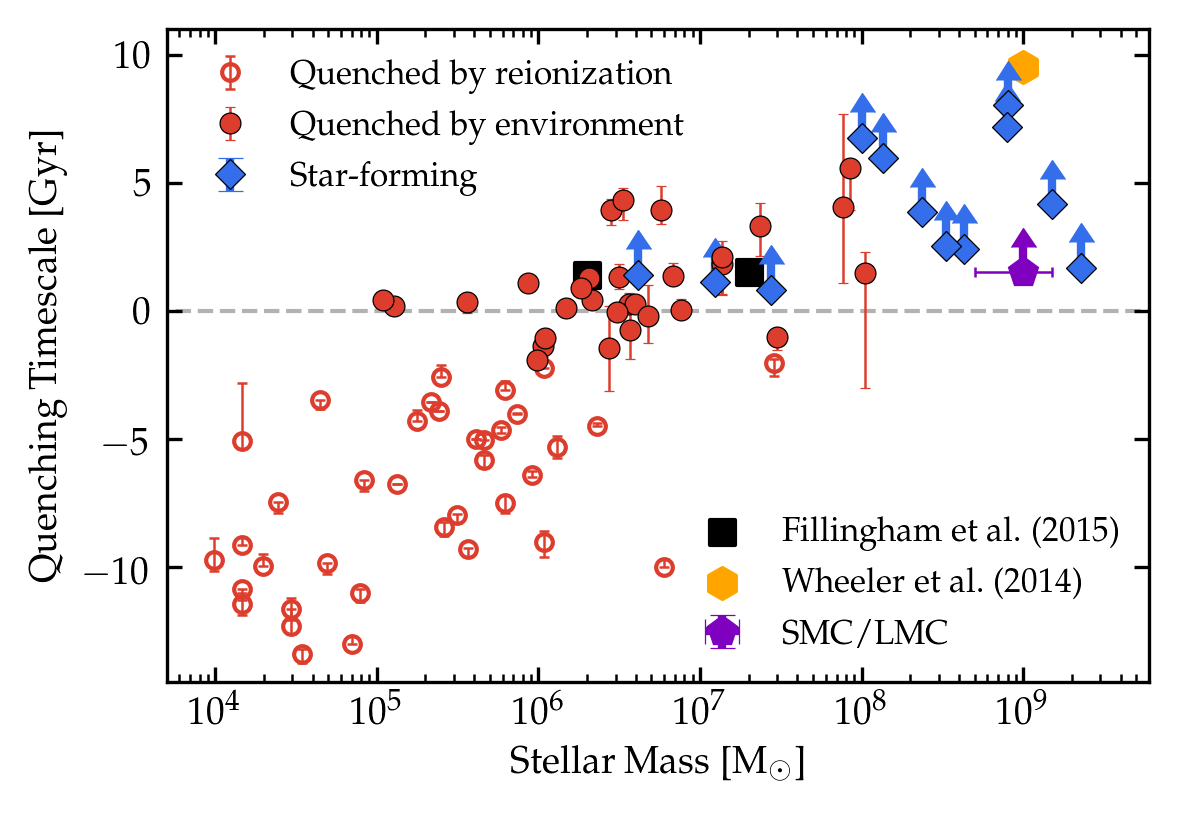

In [62]:
data = read_data()
tinfall = np.array(data.tinfall, dtype=float)
tinfall_upper_error = np.abs(np.array(data.tinfall_upper, dtype=float) - tinfall)
tinfall_lower_error = np.abs(np.array(data.tinfall_lower, dtype=float) - tinfall)

tquench = np.array(data.tquench, dtype=float)
tquench_upper_error = np.abs(np.array(data.tquench_lower, dtype=float) - tquench) # flipped intentionally
tquench_lower_error = np.abs(np.array(data.tquench_upper, dtype=float) - tquench)

tau_upper_err = np.sqrt(tquench_upper_error**2 + tinfall_upper_error**2)
tau_lower_err = np.sqrt(tquench_lower_error**2 + tinfall_lower_error**2)

fig, ax = plt.subplots(1,1,figsize=(4,2.8),dpi=300)
q = np.array(data.quenched,dtype=bool)
r = np.array((tinfall-tquench) < -2, dtype=bool) & np.array(data.tquench > 9, dtype=bool)

p1 = ax.errorbar(data.M_star[q & r], tinfall[q & r] - tquench[q & r],
            yerr = np.array([tau_lower_err[q & r], tau_upper_err[q & r]]),
            elinewidth=0.6,
            ecolor='#DD3D2D',
            capsize=1.2,
            capthick=0.6,
            fmt='o', 
            mec = '#DD3D2D',
            mfc = 'none',
            ms = 4,
            zorder=1)#, label='Quenched by reionization')

p2 = ax.errorbar(data.M_star[q & ~r], tinfall[q & ~r] - tquench[q & ~r],
            yerr = np.array([tau_lower_err[q & ~r], tau_upper_err[q & ~r]]),
            elinewidth=0.6,
            mec = 'k', 
            mew = 0.3,
            ecolor='#DD3D2D',
            capsize=1.2,
            capthick=0.6,
            fmt='o', 
            color = '#DD3D2D',
            ms = 5,
            zorder=1)#, label='Quenched by environment')

env_quench = np.array(tinfall-tquench)[q & ~r]
print(len(env_quench[np.abs(env_quench) < 1]),'quench within 1 Gyr of infall')
print(len(env_quench[env_quench < 1]),'quench earlier than 1 Gyr after infall')
print(len(env_quench[env_quench > 1]),'quench later than 1 Gyr after infall')

p3 = ax.errorbar(data.M_star[~q & ~r], tinfall[~q & ~r] - tquench[~q & ~r],
            yerr = [1]*len(tinfall[~q & ~r]),
            elinewidth=2,
            mec = 'k', 
            mew = 0.3,
            ecolor='#346eeb',
            capsize=3,
            capthick=2,
            fmt='D',
            color = '#346eeb',
            ms = 5,
            lolims=True,
            zorder=1)#, label='Star-forming')



# zero line
ax.plot([1e2, 1e10], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)


# add observational data from Fillingham et al (2015)
x = np.array([2e6, 2e7])
y = np.array([1.4, 1.5])
e1 = ax.scatter(x, y, marker='s', color='k')#, label='Fillingham+15')

# add observational data from Wheeler et al (2014)
x = np.array([1e9])
y = np.array([9.5])
e2 = ax.scatter(x, y, marker = 'h', color='orange', s=55)#, label='Wheeler+14')


# add SMC/LMC data from Kallivayalil
x = np.array([1e9])
y = np.array([1.5])
e3 = ax.errorbar(x, y, xerr = 0.001, yerr=1, 
            elinewidth=2,
            mec = '#8000bf', 
            mew = 0.3,
            ecolor='#8000bf',
            capsize=3,
            capthick=2,
            fmt='p',
            color = '#8000bf',
            ms = 7.5,
            lolims=True,
            zorder=1)#, label='SMC/LMC')

ax.errorbar(x, y,  xerr=5e8, marker = 'p', ms=0,
            ecolor='#8000bf',
            elinewidth=0.6,
            capsize=1.2,
            capthick=0.6,
            fmt='o')

leg1 = ax.legend([e1,e2,e3],['Fillingham et al. (2015)','Wheeler et al. (2014)','SMC/LMC'], loc='lower right', frameon=False, prop={'size':8})
leg2 = ax.legend([p1,p2,p3],['Quenched by reionization', 'Quenched by environment', 'Star-forming'], loc='upper left', frameon=False, prop={'size':8})
ax.add_artist(leg1)

ax.set_xlim(5e3,6e9)
ax.set_ylim(-14.5, 11)
# ax.set_ylim(-14,3)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')
# ax.legend(frameon=False, prop={'size':8}, loc='upper left')
ax.semilogx()

ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.tight_layout()
# plt.savefig('Tq_vs_mass.png', dpi=300)

plt.show()

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater


12 quench within 1 Gyr of infall
17 quench earlier than 1 Gyr after infall
13 quench later than 1 Gyr after infall


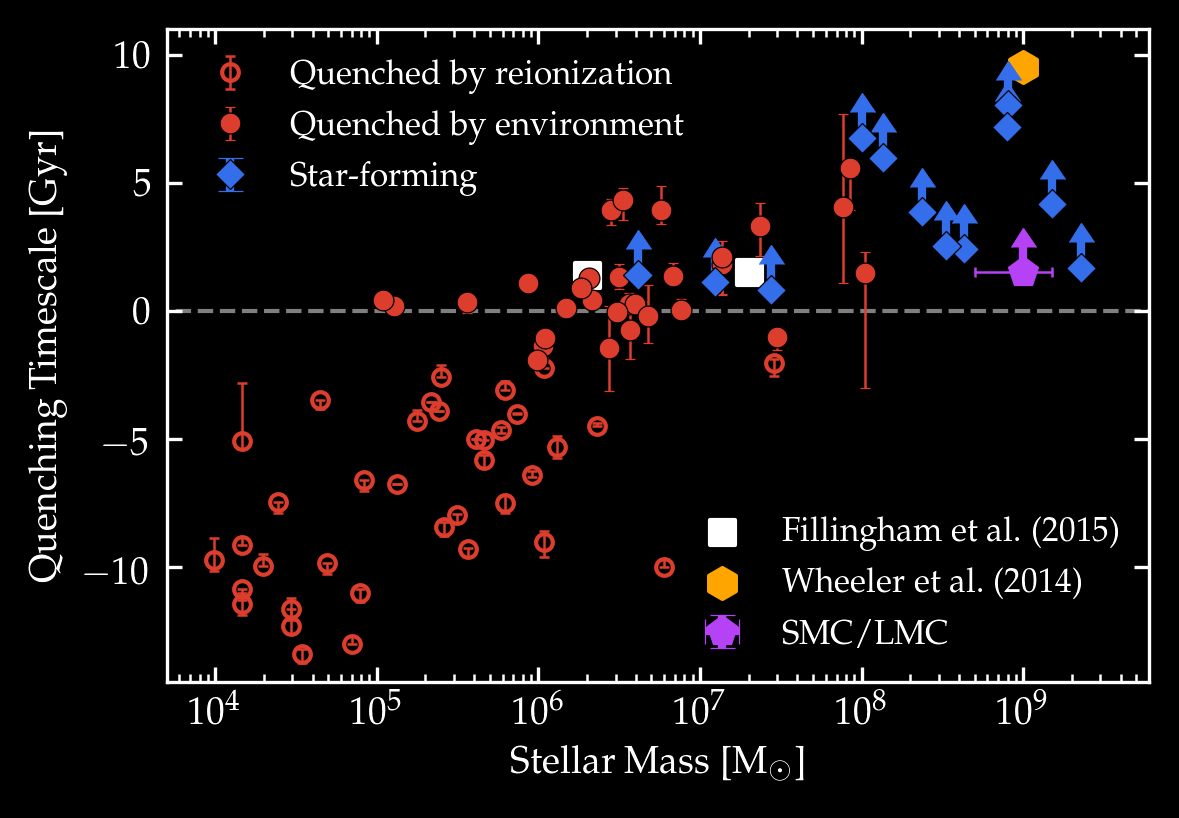

In [14]:
mpl.rcParams['text.color'] = 'w'

data = read_data()
tinfall = np.array(data.tinfall, dtype=float)
tinfall_upper_error = np.abs(np.array(data.tinfall_upper, dtype=float) - tinfall)
tinfall_lower_error = np.abs(np.array(data.tinfall_lower, dtype=float) - tinfall)

tquench = np.array(data.tquench, dtype=float)
tquench_upper_error = np.abs(np.array(data.tquench_lower, dtype=float) - tquench) # flipped intentionally
tquench_lower_error = np.abs(np.array(data.tquench_upper, dtype=float) - tquench)

tau_upper_err = np.sqrt(tquench_upper_error**2 + tinfall_upper_error**2)
tau_lower_err = np.sqrt(tquench_lower_error**2 + tinfall_lower_error**2)

fig, ax = plt.subplots(1,1,figsize=(4,2.8),dpi=300)
q = np.array(data.quenched,dtype=bool)
r = np.array((tinfall-tquench) < -2, dtype=bool) & np.array(data.tquench > 9, dtype=bool)

p1 = ax.errorbar(data.M_star[q & r], tinfall[q & r] - tquench[q & r],
            yerr = np.array([tau_lower_err[q & r], tau_upper_err[q & r]]),
            elinewidth=0.6,
            ecolor='#DD3D2D',
            capsize=1.2,
            capthick=0.6,
            fmt='o', 
            mec = '#DD3D2D',
            mfc = 'none',
            ms = 4,
            zorder=1)#, label='Quenched by reionization')

p2 = ax.errorbar(data.M_star[q & ~r], tinfall[q & ~r] - tquench[q & ~r],
            yerr = np.array([tau_lower_err[q & ~r], tau_upper_err[q & ~r]]),
            elinewidth=0.6,
            mec = 'k', 
            mew = 0.3,
            ecolor='#DD3D2D',
            capsize=1.2,
            capthick=0.6,
            fmt='o', 
            color = '#DD3D2D',
            ms = 5,
            zorder=1)#, label='Quenched by environment')

env_quench = np.array(tinfall-tquench)[q & ~r]
print(len(env_quench[np.abs(env_quench) < 1]),'quench within 1 Gyr of infall')
print(len(env_quench[env_quench < 1]),'quench earlier than 1 Gyr after infall')
print(len(env_quench[env_quench > 1]),'quench later than 1 Gyr after infall')

p3 = ax.errorbar(data.M_star[~q & ~r], tinfall[~q & ~r] - tquench[~q & ~r],
            yerr = [1]*len(tinfall[~q & ~r]),
            elinewidth=2,
            mec = 'k', 
            mew = 0.3,
            ecolor='#346eeb',
            capsize=3,
            capthick=2,
            fmt='D',
            color = '#346eeb',
            ms = 5,
            lolims=True,
            zorder=1)#, label='Star-forming')



# zero line
ax.plot([1e2, 1e10], [0,0], 'w--', linewidth=1, alpha=0.5, zorder=0)


# add observational data from Fillingham et al (2015)
x = np.array([2e6, 2e7])
y = np.array([1.4, 1.5])
e1 = ax.scatter(x, y, marker='s', color='w')#, label='Fillingham+15')

# add observational data from Wheeler et al (2014)
x = np.array([1e9])
y = np.array([9.5])
e2 = ax.scatter(x, y, marker = 'h', color='orange', s=55)#, label='Wheeler+14')


# add SMC/LMC data from Kallivayalil
x = np.array([1e9])
y = np.array([1.5])
e3 = ax.errorbar(x, y, xerr = 0.001, yerr=1, 
            elinewidth=2,
            mec = '#b642f5', 
            mew = 0.3,
            ecolor='#b642f5',
            capsize=3,
            capthick=2,
            fmt='p',
            color = '#b642f5',
            ms = 7.5,
            lolims=True,
            zorder=1)#, label='SMC/LMC')

ax.errorbar(x, y,  xerr=5e8, marker = 'p', ms=0,
            ecolor='#b642f5',
            elinewidth=0.6,
            capsize=1.2,
            capthick=0.6,
            fmt='o')

leg1 = ax.legend([e1,e2,e3],['Fillingham et al. (2015)','Wheeler et al. (2014)','SMC/LMC'], loc='lower right', frameon=False, prop={'size':8})
leg2 = ax.legend([p1,p2,p3],['Quenched by reionization', 'Quenched by environment', 'Star-forming'], loc='upper left', frameon=False, prop={'size':8})
ax.add_artist(leg1)



fig.patch.set_facecolor('black')
ax.set_facecolor('black')

ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w') 
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('w')

ax.yaxis.label.set_color('w')
ax.xaxis.label.set_color('w')

ax.title.set_color('w')

    

ax.set_xlim(5e3,6e9)
ax.set_ylim(-14.5, 11)
# ax.set_ylim(-14,3)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Quenching Timescale [Gyr]')
# ax.legend(frameon=False, prop={'size':8}, loc='upper left')
ax.semilogx()

ax.tick_params(direction='in',which='both', colors='w')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig('Tq_vs_mass_present.png', dpi=300, facecolor='k')

plt.show()

mpl.rcParams['text.color'] = 'k'

# Histogram of timescale differences

This allows us to see what fraction of the satellies that quench after infall lose their gas within x Gyr of infall, etc. 

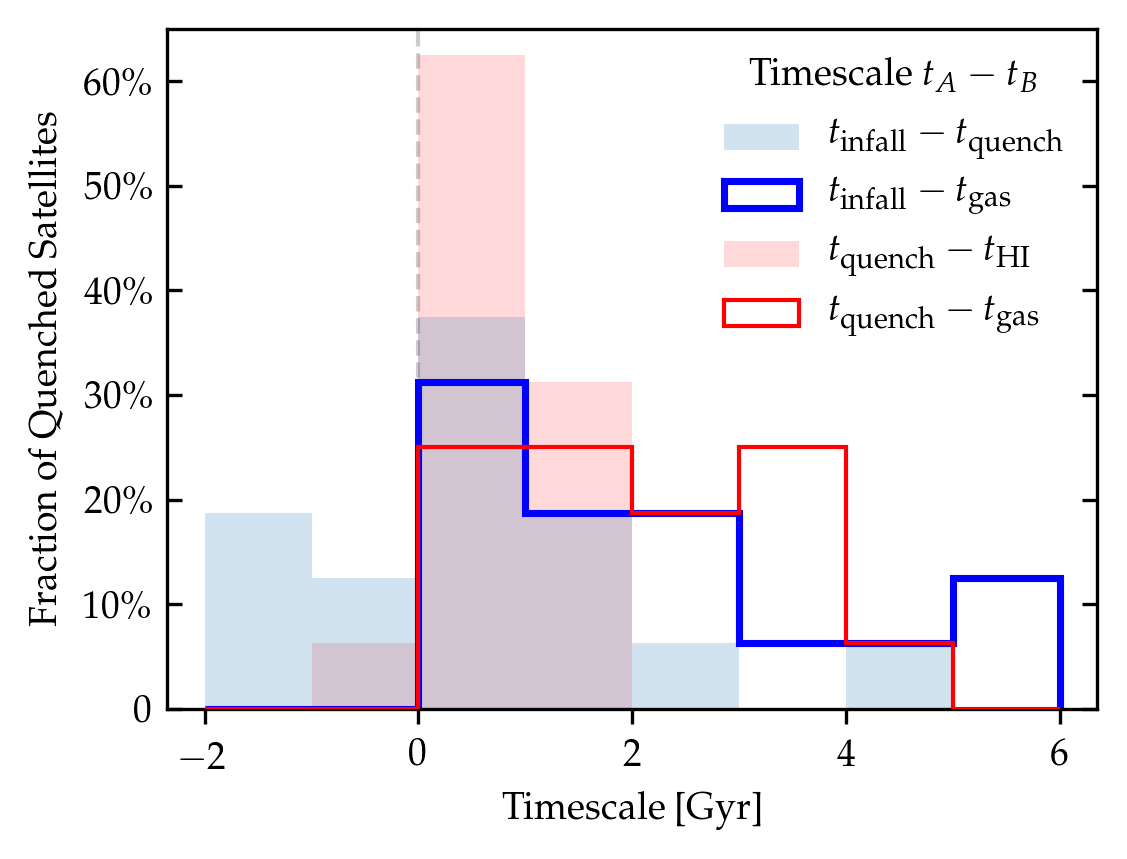

In [60]:
data = read_data()
data = data[~np.isnan(np.array(data.tinfall,dtype=float)) & np.array(data.quenched,dtype=bool) & ~np.array(data.has_gas,dtype=bool)]
env = np.array((data.tinfall-data.tquench) > -2, dtype=bool) & np.array(data.tquench < 9, dtype=bool)
data = data[env]

tHI = np.array(data.tHI_upper, dtype=float) # i'm using the upper limit here because i want to use 0.2 as the threshold but don't want to re-run everything yet
tgas = np.array(data.tgasloss, dtype=float)
tinfall = np.array(data.tinfall, dtype=float)
tquench = np.array(data.tquench,dtype=float)
mstar = np.array(data.M_star, dtype=float)

plt.figure(figsize=(4,3),dpi=300)
bins = np.arange(-2,7,1)


plt.hist(tinfall-tquench, alpha=0.2,label=r'$t_{\mathrm{infall}} - t_{\mathrm{quench}}$', 
         weights=np.ones(len(tinfall-tgas)) / len(tinfall-tgas), density=False, linestyle='-',zorder=1,linewidth=1, bins=bins)

plt.hist(tinfall - tgas, histtype='step', label=r'$t_{\mathrm{infall}} - t_{\mathrm{gas}}$', 
         weights=np.ones(len(tinfall-tgas)) / len(tinfall-tgas), density=False, linestyle='-',zorder=2,linewidth=1.7, bins=bins, color='b')

plt.hist(tquench - tHI, alpha=0.15, label=r'$t_{\mathrm{quench}} - t_{\mathrm{HI}}$', 
         weights=np.ones(len(tquench-tgas)) / len(tquench-tgas), density=False, linestyle='-',zorder=0,linewidth=1, bins=bins, color='r')

plt.hist(tquench - tgas, histtype='step', label=r'$t_{\mathrm{quench}} - t_{\mathrm{gas}}$', 
         weights=np.ones(len(tquench-tgas)) / len(tquench-tgas), density=False, linestyle='-',zorder=3,linewidth=1, bins=bins, color='r')



plt.plot([0,0],[0,1],'k--', linewidth=1, zorder=0, alpha=0.2)
plt.ylim(0,0.65)
plt.xlim(-2.35, 6.35)
plt.ylabel('Fraction of Quenched Satellites')
plt.xlabel('Timescale [Gyr]')
leg = plt.legend(frameon=False, title=r'Timescale $t_A - t_B$', loc='upper right')
# leg._legend_box.align = "right"
# plt.annotate(r'$t_B$ before $t_A$', (-11, 0.2),size=10)
# plt.annotate(r'$t_A$ before $t_B$', (8, 0.2),size=10)
plt.gca().tick_params(axis='y',direction='in',which='both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().set_yticklabels([0,r'10\%',r'20\%',r'30\%',r'40\%',r'50\%',r'60\%'])

# plt.subplots_adjust(left=0.1)

plt.savefig('timescale_hist_env.png', dpi=300, bbox_inches = "tight")
plt.show()

# Quenching Time vs Infall Time

First, the large plot that went in the paper

Loading...	loaded data


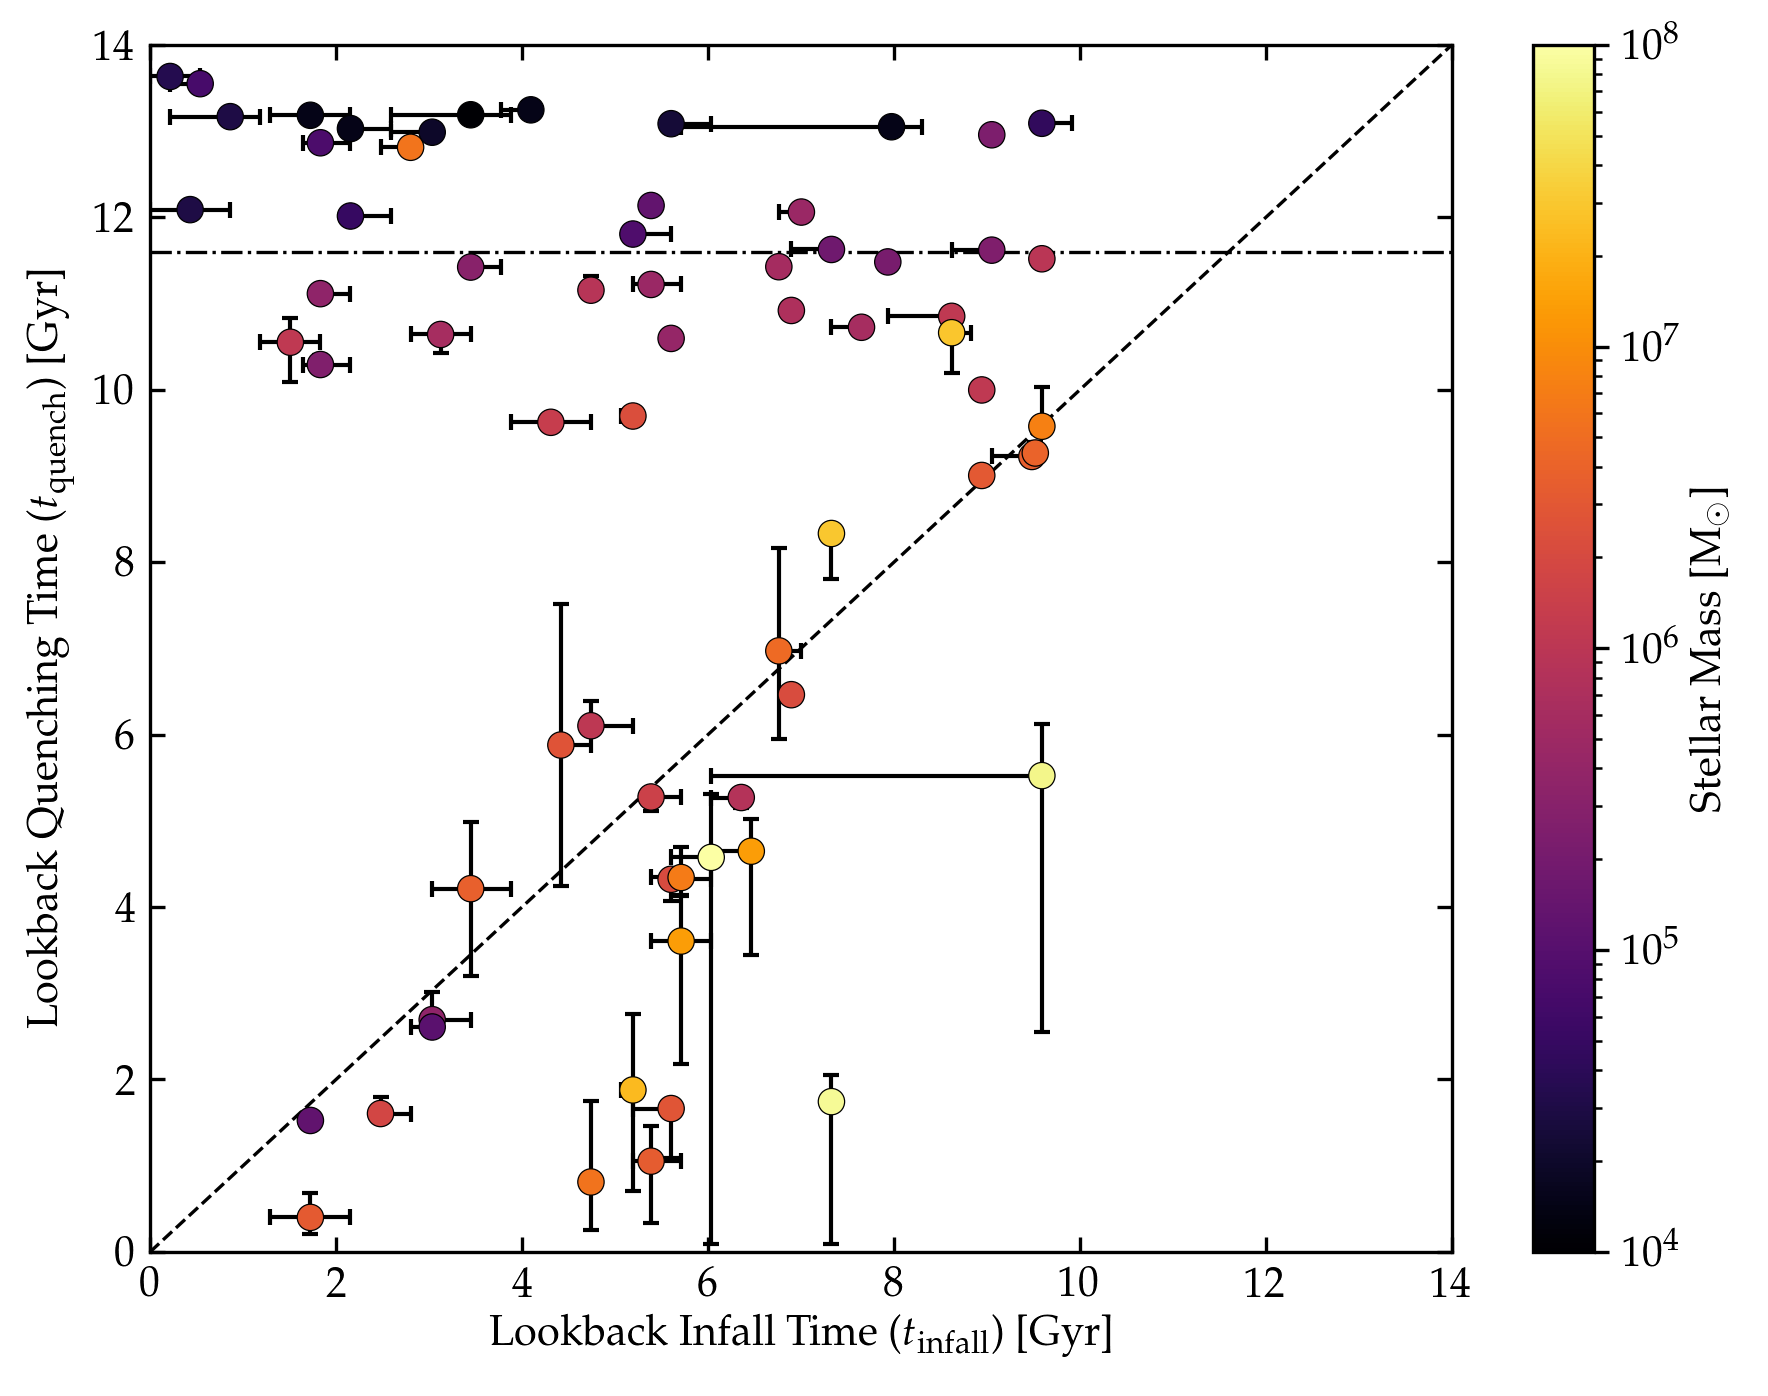

In [124]:
 
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching


fig, ax = plt.subplots(1,1,figsize=(5.91,4.5),dpi=300)

print('Loading...', end='\t')
data = read_data()

data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))]
data = data[~((data.sim=='h148')&(data.haloid==759))]


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_upper), np.abs(tinfall-tinfall_lower)]),
             yerr = np.array([np.abs(tquench-tquench_upper), np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)

# for i, (haloid, simulation) in enumerate(zip(newids, sim)):
#     if tinfall[i] != None and tquench[i] != None:
#         ax.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tquench[i]+0.2), size=5)


cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')


ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.savefig('QT_IT.png', dpi=300)
plt.show()

Loading...	loaded data


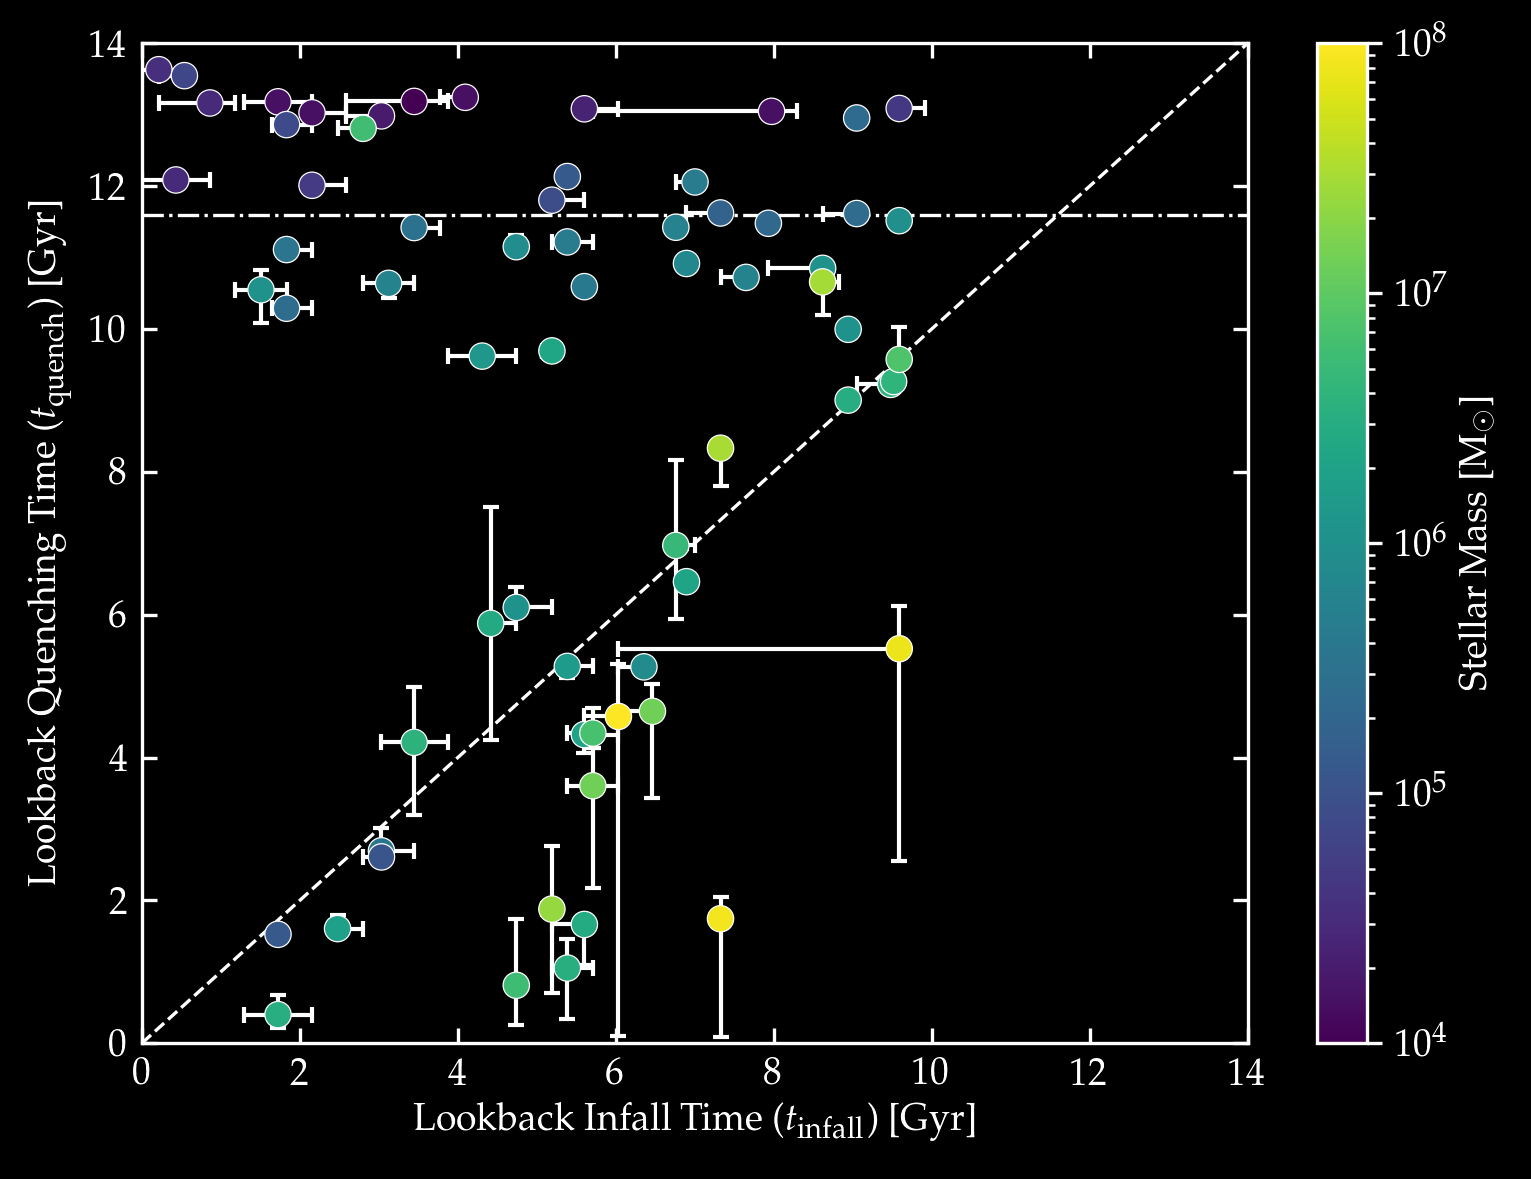

In [22]:
mpl.rcParams['text.color'] = 'w'
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching

plt.style.use('dark_background')

fig, ax = plt.subplots(1,1,figsize=(5.25,4),dpi=300)

print('Loading...', end='\t')
data = read_data()

data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))]
data = data[~((data.sim=='h148')&(data.haloid==759))]


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_upper), np.abs(tinfall-tinfall_lower)]),
             yerr = np.array([np.abs(tquench-tquench_upper), np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='w',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'w',
                 cmap = 'viridis', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='w', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='w', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)


fig.patch.set_facecolor('black')
ax.set_facecolor('black')

ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w') 
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('w')

ax.yaxis.label.set_color('w')
ax.xaxis.label.set_color('w')


ax.title.set_color('w')


cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')


ax.tick_params(direction='in',which='both', colors='w')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig('QT_IT_Present.png', dpi=300, facecolor='k')
plt.show()


mpl.rcParams['text.color'] = 'k'

Then, the same plot but with simulation and halo IDs labeled so that we can look into interesting halos as case studies. 

Loading...	loaded data


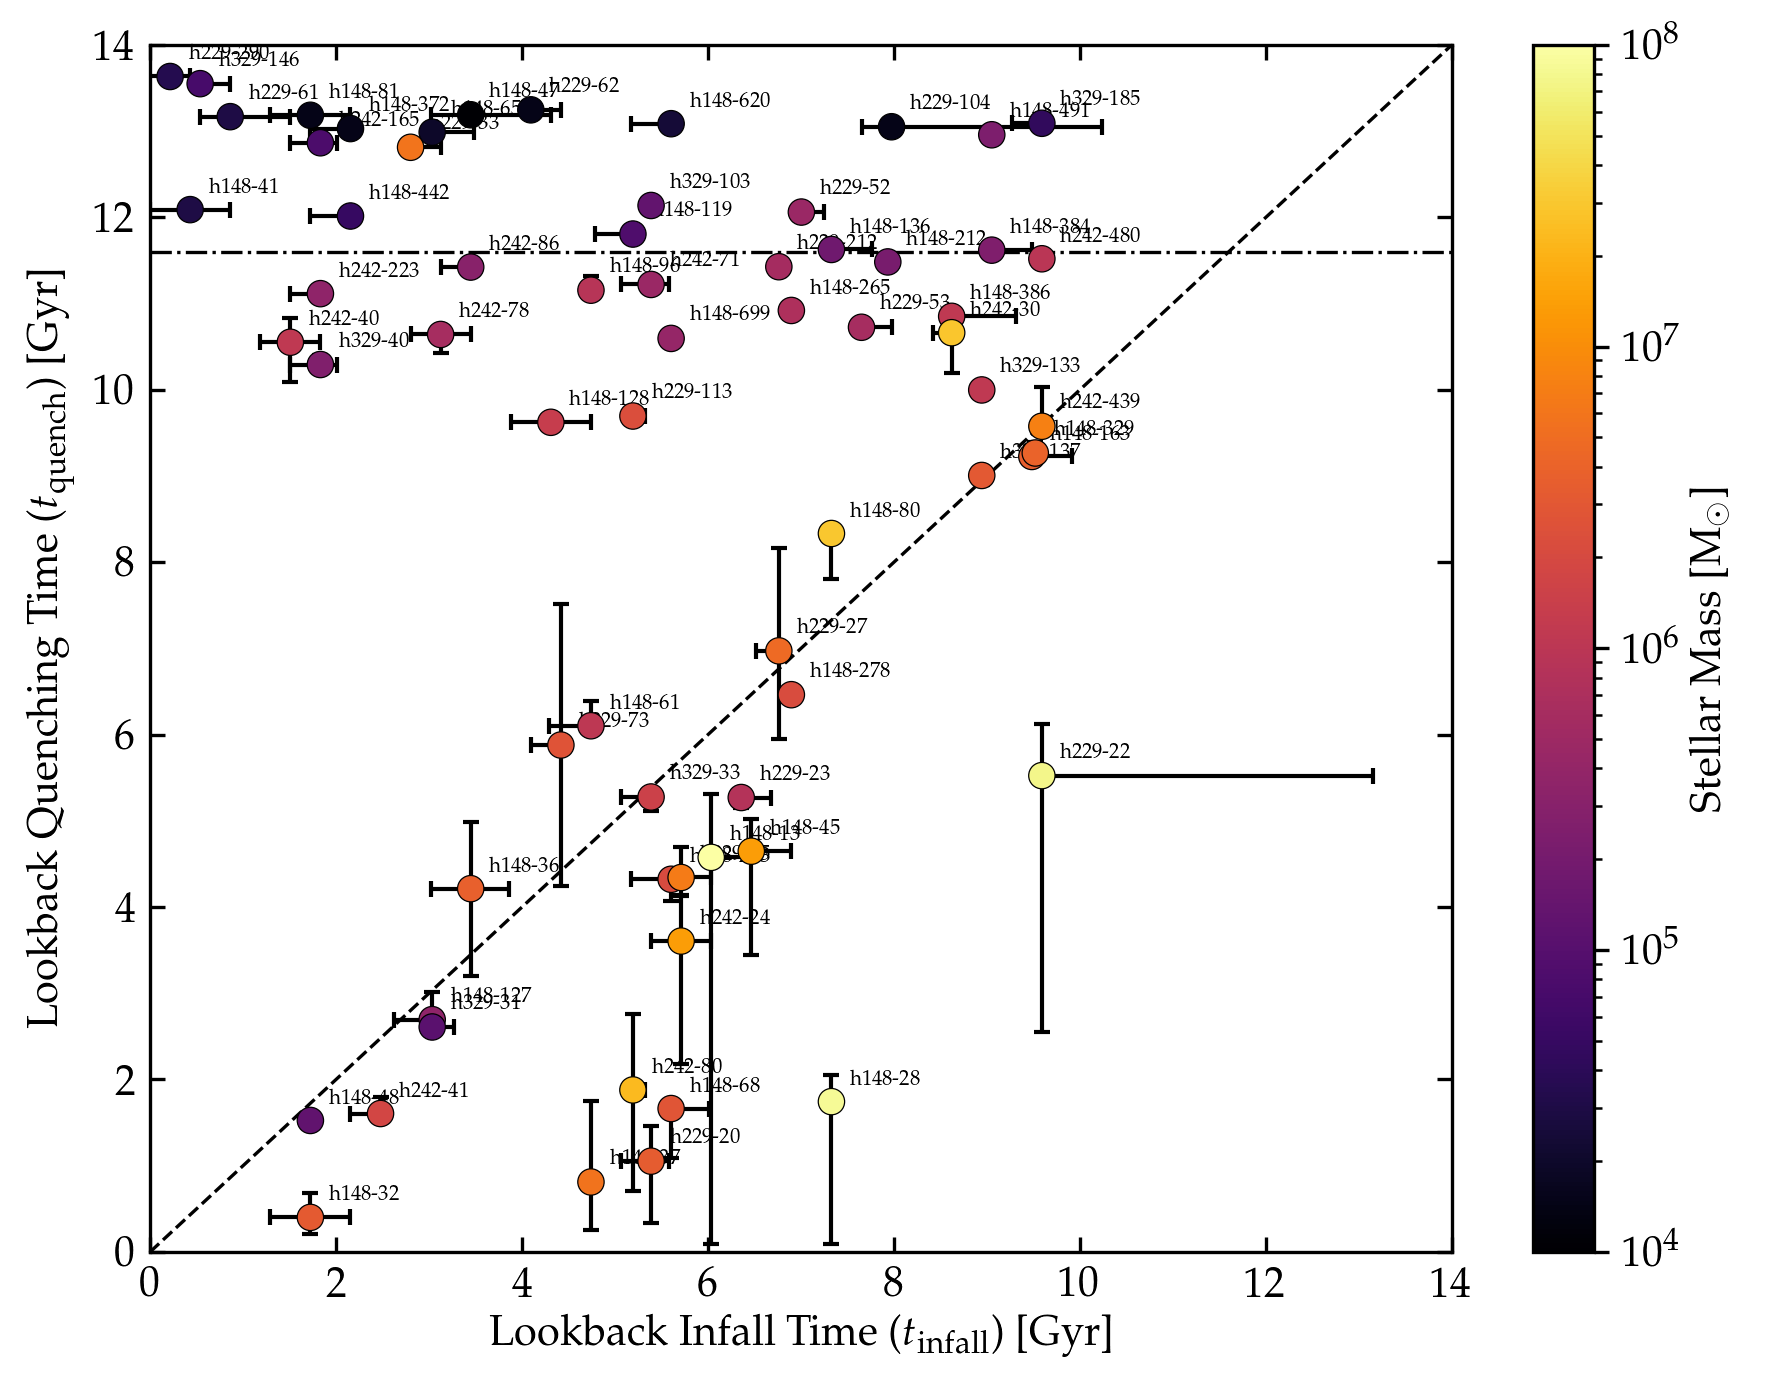

In [101]:
 
reiontime = 11.6 # according to Brown et al (2014), 100% of star formation cuts off by 11.6 Gyr ago in reionization quenching


fig, ax = plt.subplots(1,1,figsize=(7,5.33),dpi=300)

print('Loading...', end='\t')
data = read_data()

data = data[(~np.isnan(np.array(data.tinfall,dtype=float)))&(np.array(data.quenched,dtype=bool))]
data = data[~((data.sim=='h148')&(data.haloid==759))]


tinfall = np.array(data.tinfall, dtype=float)
tinfall_lower = np.array(data.tinfall_lower,dtype=float)
tinfall_upper = np.array(data.tinfall_upper,dtype=float)
tquench = np.array(data.tquench, dtype=float)
tquench_lower = np.array(data.tquench_lower,dtype=float)
tquench_upper = np.array(data.tquench_upper,dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

print('loaded data')


ax.errorbar(tinfall, tquench,
             xerr = np.array([np.abs(tinfall-tinfall_lower), np.abs(tinfall-tinfall_upper)]),
             yerr = np.array([np.abs(tquench-tquench_upper),np.abs(tquench-tquench_lower)]),
             fmt = 'o',
             elinewidth=1,
             ecolor='k',
             capsize=2,
             capthick=1,
             mfc = 'none',
             mec = 'none',
             ms = 0,
             zorder = 10)

im = ax.scatter(tinfall, tquench,
                 c = mstar,
                 linewidths = 0.3,
                 edgecolors = 'k',
                 cmap = 'inferno', 
                 norm = mpl.colors.LogNorm(),
                 marker = 'o',
                 s = 40,
                 vmin = 1e4,
                 vmax = 1e8,
                 zorder = 11)

# plot diagonal line
ax.plot([0,20],[0,20], '--', linewidth=0.8, color='k', zorder=0) 
# plot reionization line
ax.plot([0,20],[reiontime,reiontime], '-.', linewidth=0.8, color='k', zorder=1)
ax.set_xlabel('Lookback Infall Time ($t_{\mathrm{infall}}$) [Gyr]')
ax.set_ylabel('Lookback Quenching Time ($t_{\mathrm{quench}}$) [Gyr]')
ax.set_xlim(0,14)
ax.set_ylim(0,14)

for i, (haloid, simulation) in enumerate(zip(newids, sim)):
    if tinfall[i] != None and tquench[i] != None:
        ax.annotate(str(simulation)+'-'+str(int(haloid)), (tinfall[i]+0.2, tquench[i]+0.2), size=5)


cbar = plt.colorbar(im, ax = ax) 
cbar.ax.set_ylabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')


ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

# plt.savefig('QT_IT.png', dpi=300)
plt.show()

# Gas-loss timescale vs quenching timescale 

This plot lets us see which satellites hang on to their gas and which lose it rapidly

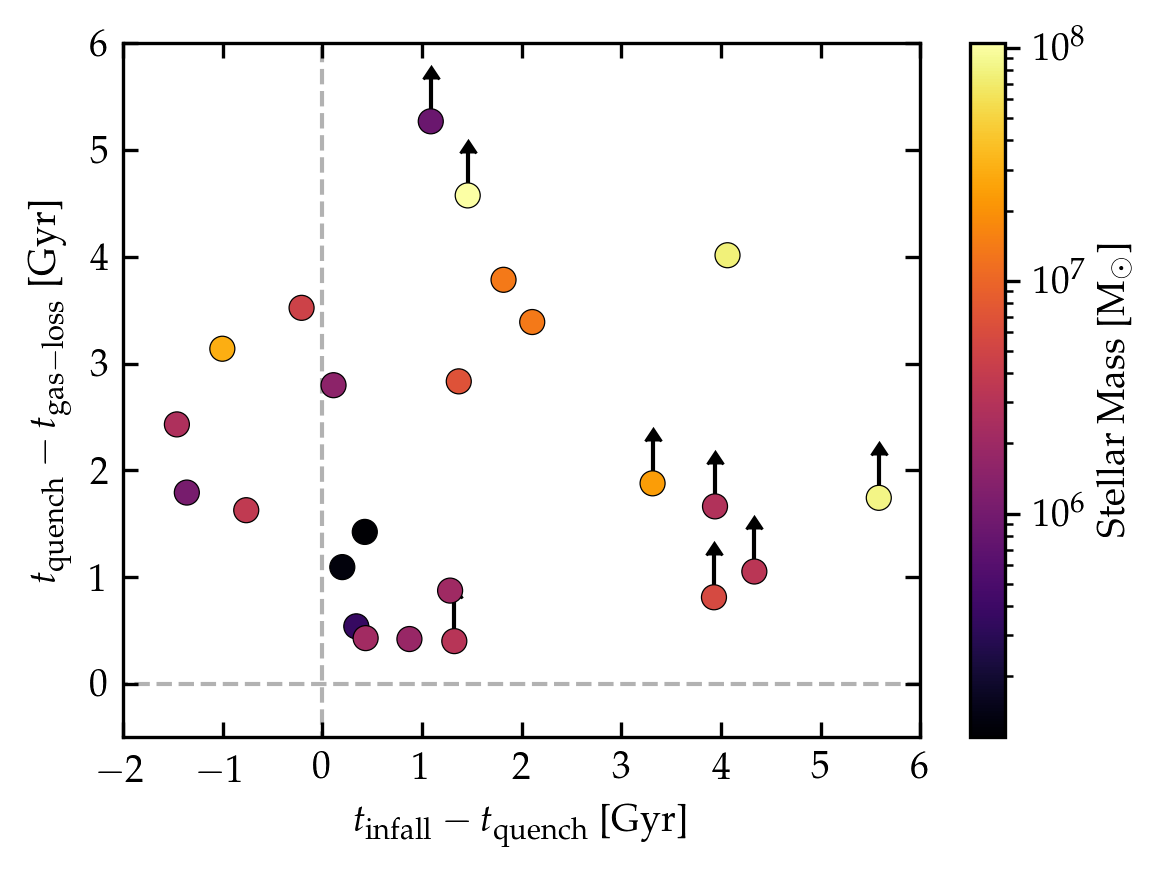

In [45]:
data = read_data()
data = data[(data.quenched) & (~np.isnan(data.tinfall))]

env = np.array((data.tinfall-data.tquench) > -2, dtype=bool) & np.array(data.tquench < 9, dtype=bool)
data = data[env]

tinfall = np.array(data.tinfall,dtype=float)

tquench = np.array(data.tquench, dtype=float)
tquench_upper_error = np.abs(np.array(data.tquench_lower, dtype=float) - tquench) # flipped intentionally
tquench_lower_error = np.abs(np.array(data.tquench_upper, dtype=float) - tquench)

tgas = np.array(data.tgasloss, dtype=float)
tgas_upper_error = np.abs(np.array(data.tgasloss_upper, dtype=float) - tgas)
tgas_lower_error = np.abs(np.array(data.tgasloss_lower, dtype=float) - tgas)

tau_upper_err = np.sqrt(tquench_upper_error**2 + tgas_upper_error**2)
tau_lower_err = np.sqrt(tquench_lower_error**2 + tgas_lower_error**2)

fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=300)
q = np.array(data.has_gas,dtype=bool)

ax.errorbar(tinfall[q]-tquench[q], tquench[q]-tgas[q], yerr = 0.4, elinewidth=1, 
            mew = 0.7,
            ecolor='k',
            capsize=2,
            capthick=1,
            fmt='o',
            mec = 'none',
            mfc = 'none',
            ms = 0,
            lolims=True,)

im = ax.scatter(tinfall-tquench, tquench-tgas, c=data.M_star, cmap='inferno', norm=mpl.colors.LogNorm(), linewidths=0.3, edgecolor='k', zorder=100)
cbar = fig.colorbar(im,ax=ax)
cbar.set_label(r'Stellar Mass [$\mathrm{M}_{\odot}$]')

# zero line
ax.plot([-3, 7], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)
ax.plot([0,0], [-1, 7], 'k--', linewidth=1, alpha=0.3, zorder=0)

ax.set_xlim(-2, 6)
ax.set_ylim(-0.5, 6)
# ax.set_ylim(-14,3)

ax.set_xlabel('$t_{\mathrm{infall}}-t_{\mathrm{quench}}$ [Gyr]')
ax.set_ylabel('$t_{\mathrm{quench}}-t_{\mathrm{gas-loss}}$ [Gyr]')

ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_xticks([-2,-1,0,1,2,3,4,5,6])

plt.tight_layout()
plt.savefig('Gas_v_Infall.png', dpi=300)

plt.show()

# Periapsis and eccentricity

While I didn't end up using this plot, it is useful to have as a null result.

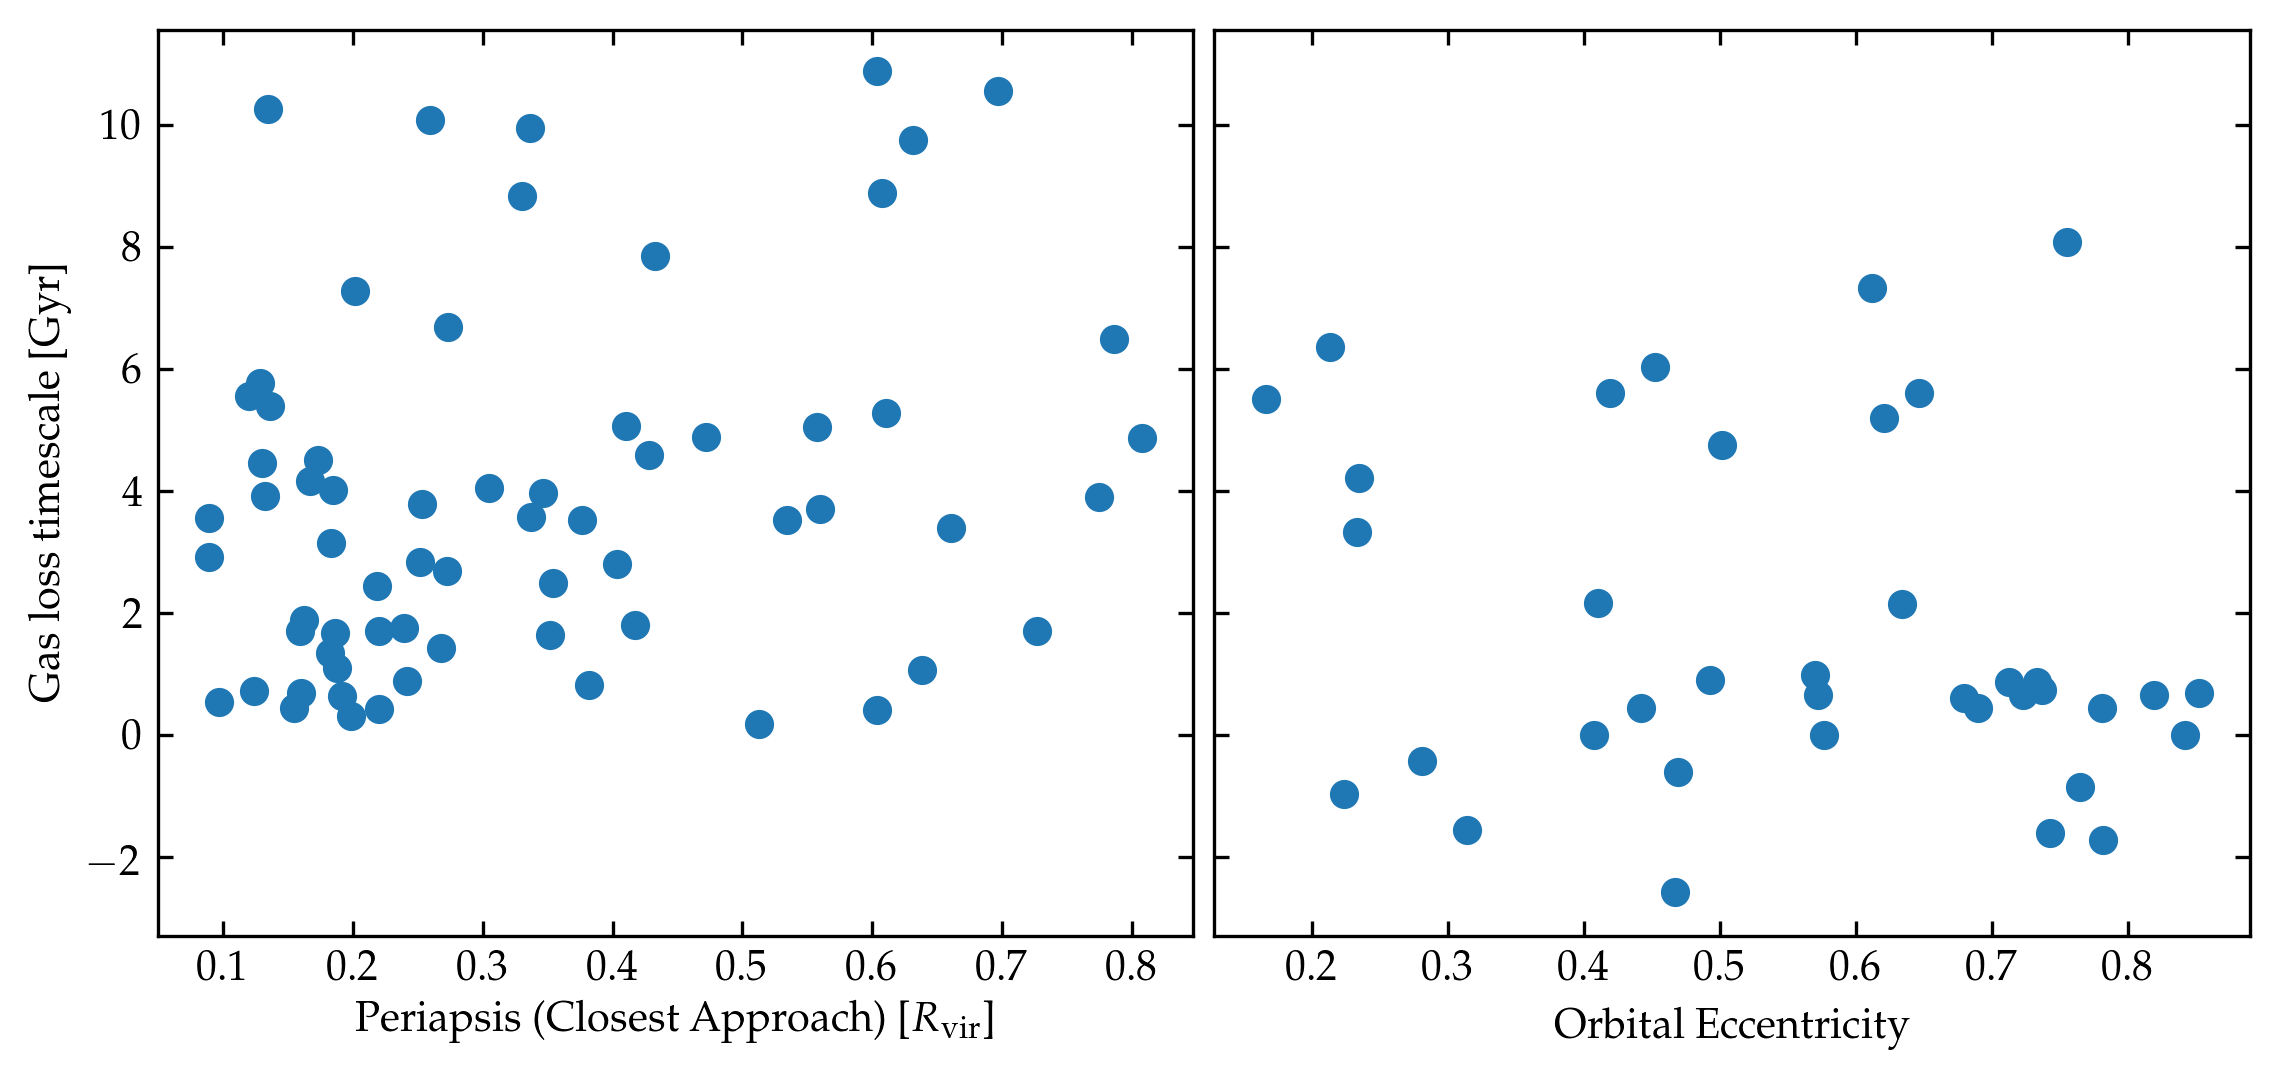

In [103]:

tinfall = np.array(data.tinfall, dtype=float)
tquench = np.array(data.tquench, dtype=float)

tgasloss = np.array(data.tgasloss, dtype=float)
thi = np.array(data.tHI, dtype=float)
newids = np.array(data.haloid, dtype=int)
sim = np.array(data.sim, dtype=str)
# mstar = np.array(data.M_star, dtype=float)
mvir = np.array(data.mass, dtype=float)
ecc = np.array(data.eccentricity, dtype=float)
periapsis = np.array(data.periapsis, dtype=float)

fig, ax = plt.subplots(1,2,figsize=(9,4),sharey=True, dpi=300)

ax[0].scatter(periapsis, tquench-tgasloss)                    # change this to tinfall-tquench if you want quenching timescale
ax[0].set_xlabel('Periapsis (Closest Approach) [$R_{\mathrm{vir}}$]')
ax[0].set_ylabel('Gas loss timescale [Gyr]')        

ax[1].scatter(ecc, tinfall-tgasloss)                       # and this
ax[1].set_xlabel('Orbital Eccentricity')

ax[0].tick_params(direction='in',which='both')
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[1].tick_params(direction='in',which='both')
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')

plt.subplots_adjust(wspace=0.02)
plt.show()

# Additional Plots that I didn't end up using

Histograms of timescale differences for other subsamples and other values. 

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


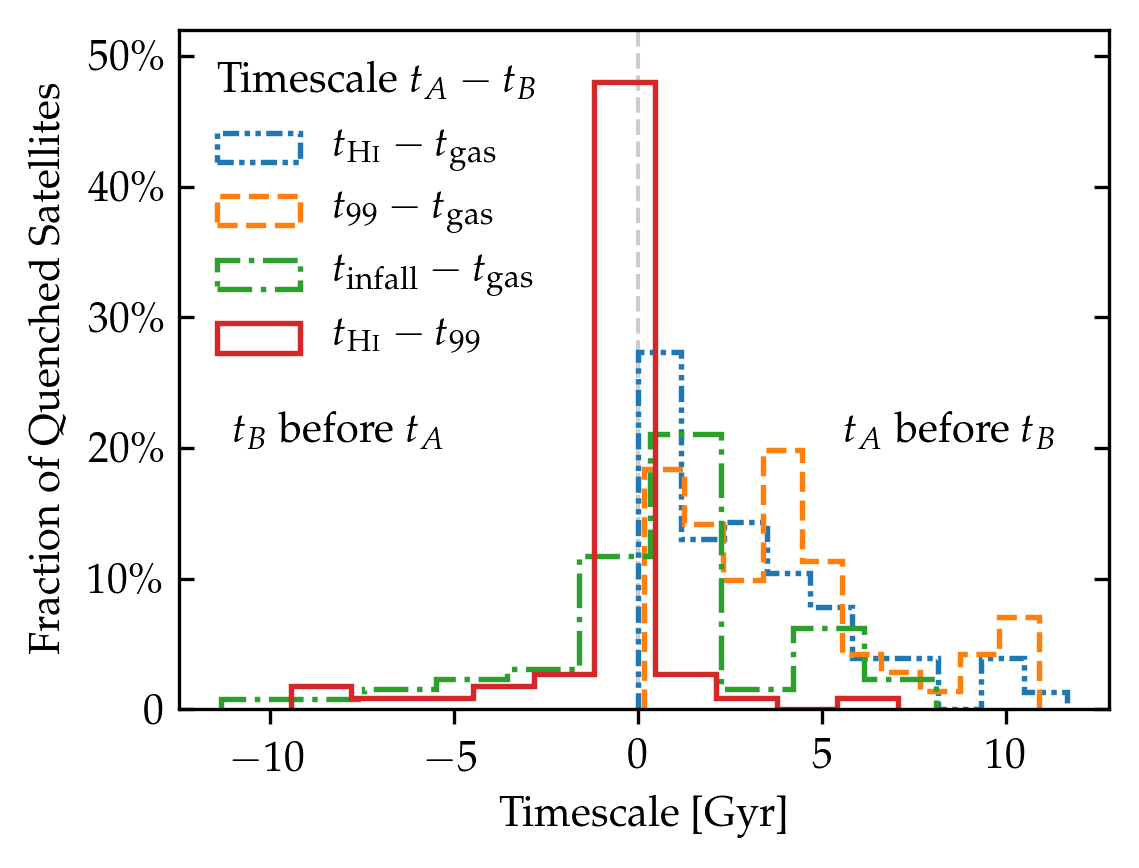

In [320]:
data = read_data()
data = data[~np.isnan(np.array(data.tinfall,dtype=float)) & np.array(data.quenched,dtype=bool)]

tHI = np.array(data.tHI, dtype=float)
tgas = np.array(data.tgasloss, dtype=float)
tinfall = np.array(data.tinfall, dtype=float)
tquench = np.array(data.tquench,dtype=float)
mstar = np.array(data.M_star, dtype=float)


plt.figure(figsize=(4,3),dpi=300)
plt.hist(tHI-tgas, histtype='step',label=r'$t_{\scriptsize\textsc{Hi}} - t_{\mathrm{gas}}$', density=True, linestyle=(0, (3, 1, 1, 1, 1, 1)),zorder=1,linewidth=1.3)
plt.hist(tquench - tgas, histtype='step', label=r'$t_{99} - t_{\mathrm{gas}}$', density=True, linestyle='--',zorder=1,linewidth=1.3)
# plt.hist(t300 - tquench, histtype='step', label=r'$t_{300} - t_{99}$', density=True)
plt.hist(tinfall - tgas, histtype='step', label=r'$t_{\mathrm{infall}} - t_{\mathrm{gas}}$', density=True, linestyle='-.',zorder=1,linewidth=1.3)
plt.hist(tHI - tquench, histtype='step', label=r'$t_{\scriptsize\textsc{Hi}} - t_{99}$', density=True,zorder=1,linewidth=1.3)


plt.plot([0,0],[0,1],'k--', linewidth=1, zorder=0, alpha=0.2)
plt.ylim(0,0.52)
plt.ylabel('Fraction of Quenched Satellites')
plt.xlabel('Timescale [Gyr]')
leg = plt.legend(frameon=False, title=r'Timescale $t_A - t_B$', loc='upper left')
leg._legend_box.align = "left"
plt.annotate(r'$t_B$ before $t_A$', (-11, 0.2),size=10)
plt.annotate(r'$t_A$ before $t_B$', (5.6, 0.2),size=10)
plt.gca().tick_params(axis='y',direction='in',which='both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().set_yticklabels([0,r'10\%',r'20\%',r'30\%',r'40\%',r'50\%'])

# plt.subplots_adjust(left=0.1)

plt.savefig('timescale_hist.png', dpi=300, bbox_inches = "tight")
plt.show()

In [3]:
data = read_data()
data = data[~np.isnan(np.array(data.tinfall,dtype=float)) & np.array(data.quenched,dtype=bool)]
data = data[data.tinfall-data.tquench > 0]

tHI = np.array(data.tHI, dtype=float)
tgas = np.array(data.tgasloss, dtype=float)
tinfall = np.array(data.tinfall, dtype=float)
tquench = np.array(data.tquench,dtype=float)
mstar = np.array(data.M_star, dtype=float)


plt.figure(figsize=(4,3),dpi=300)
plt.hist(tinfall-tquench, histtype='step',label=r'$t_{\mathrm{infall}} - t_{\mathrm{quench}}$', weights=np.ones(len(tinfall-tgas)) / len(tinfall-tgas), density=False, linestyle='-',zorder=1,linewidth=1.3)
plt.hist(tquench - tgas, histtype='step', label=r'$t_{quench} - t_{\mathrm{gas}}$', weights=np.ones(len(tquench-tgas)) / len(tquench-tgas), density=False, linestyle='--',zorder=1,linewidth=1.3)
# plt.hist(t300 - tquench, histtype='step', label=r'$t_{300} - t_{99}$', density=True)
plt.hist(tinfall - tgas, histtype='step', label=r'$t_{\mathrm{infall}} - t_{\mathrm{gas}}$', weights=np.ones(len(tinfall-tgas)) / len(tinfall-tgas), density=False, linestyle='-.',zorder=1,linewidth=1.3, color='r')
# plt.hist(tHI - tquench, histtype='step', label=r'$t_{\scriptsize\textsc{Hi}} - t_{99}$', density=True,zorder=1,linewidth=1.3)


plt.plot([0,0],[0,1],'k--', linewidth=1, zorder=0, alpha=0.2)
plt.ylim(0,0.45)
plt.ylabel('Fraction of Quenched Satellites')
plt.xlabel('Timescale [Gyr]')
leg = plt.legend(frameon=False, title=r'Timescale $t_A - t_B$', loc='upper right')
leg._legend_box.align = "right"
# plt.annotate(r'$t_B$ before $t_A$', (-11, 0.2),size=10)
plt.annotate(r'$t_A$ before $t_B$', (8, 0.2),size=10)
plt.gca().tick_params(axis='y',direction='in',which='both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().set_yticklabels([0,r'10\%',r'20\%',r'30\%',r'40\%'])

# plt.subplots_adjust(left=0.1)

plt.savefig('timescale_hist_env.png', dpi=300, bbox_inches = "tight")
plt.show()

NameError: name 'read_data' is not defined

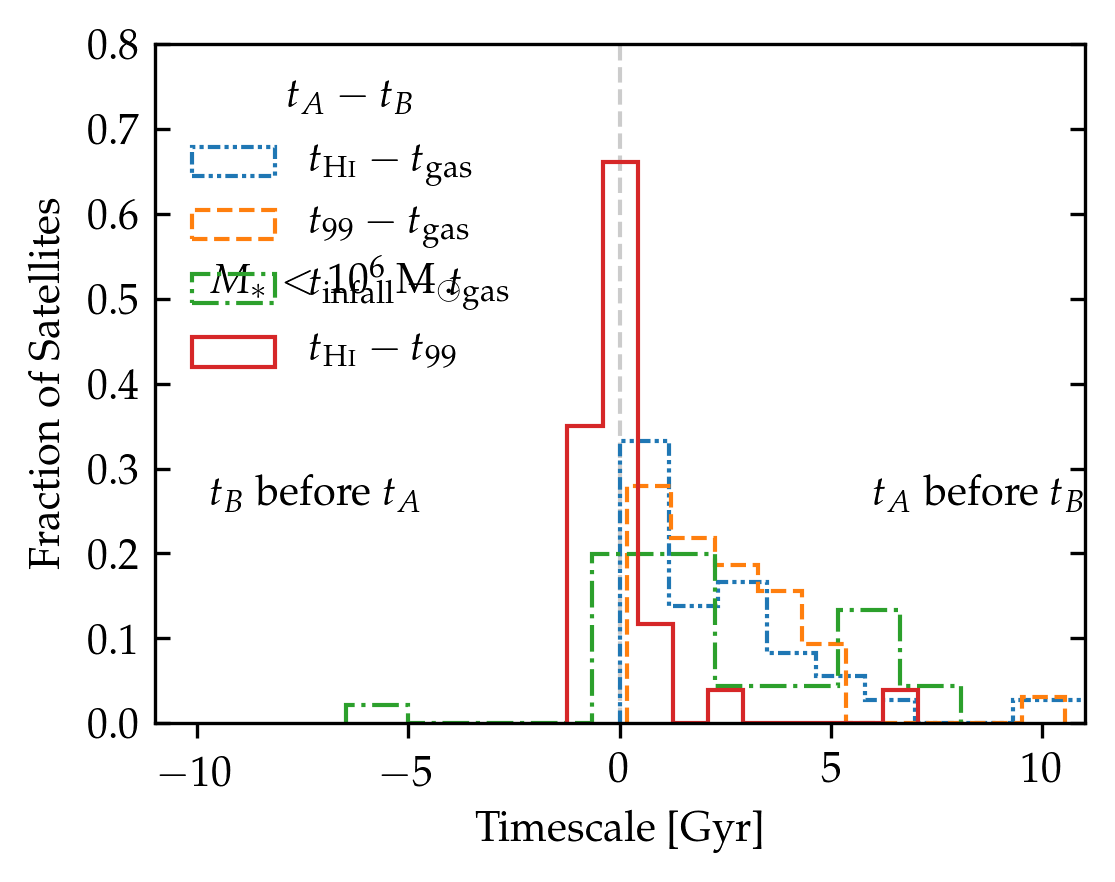

In [123]:
f = mstar > 1e6
tHI_small = tHI[f]
tgas_small = tgas[f]
tquench_small = tquench[f]
tinfall_small = tinfall[f]

plt.figure(figsize=(4,3),dpi=300)
plt.hist(tHI_small-tgas_small, histtype='step',label=r'$t_{\scriptsize\textsc{Hi}} - t_{\mathrm{gas}}$', density=True, linestyle=(0, (3, 1, 1, 1, 1, 1)),zorder=1)
plt.hist(tquench_small - tgas_small, histtype='step', label=r'$t_{99} - t_{\mathrm{gas}}$', density=True, linestyle='--',zorder=1)
# plt.hist(t300 - tquench, histtype='step', label=r'$t_{300} - t_{99}$', density=True)
plt.hist(tinfall_small - tgas_small, histtype='step', label=r'$t_{\mathrm{infall}} - t_{\mathrm{gas}}$', density=True, linestyle='-.',zorder=1)
plt.hist(tHI_small - tquench_small, histtype='step', label=r'$t_{\scriptsize\textsc{Hi}} - t_{99}$', density=True,zorder=1)


plt.plot([0,0],[0,1],'k--', linewidth=1, zorder=0, alpha=0.2)
plt.ylim(0,0.8)
plt.ylabel('Fraction of Satellites')
plt.xlabel('Timescale [Gyr]')
plt.legend(frameon=False, title=r'$t_A - t_B$')
plt.annotate(r'$M_* < 10^6\ \mathrm{M}_{\odot}$', (-9.7,0.5))
plt.annotate(r'$t_B$ before $t_A$', (-9.7, 0.25),size=10)
plt.annotate(r'$t_A$ before $t_B$', (6, 0.25),size=10)
plt.gca().tick_params(axis='y',direction='in',which='both')
plt.gca().yaxis.set_ticks_position('both')
# plt.gca().set_yticklabels([0,r'10\%',r'20\%',r'30\%',r'40\%',r'50\%',r'60\%'])
plt.xlim(-11,11)
# plt.subplots_adjust(left=0.1)

# plt.savefig('timescale_hist_small.png', dpi=300, bbox_inches = "tight")
plt.show()

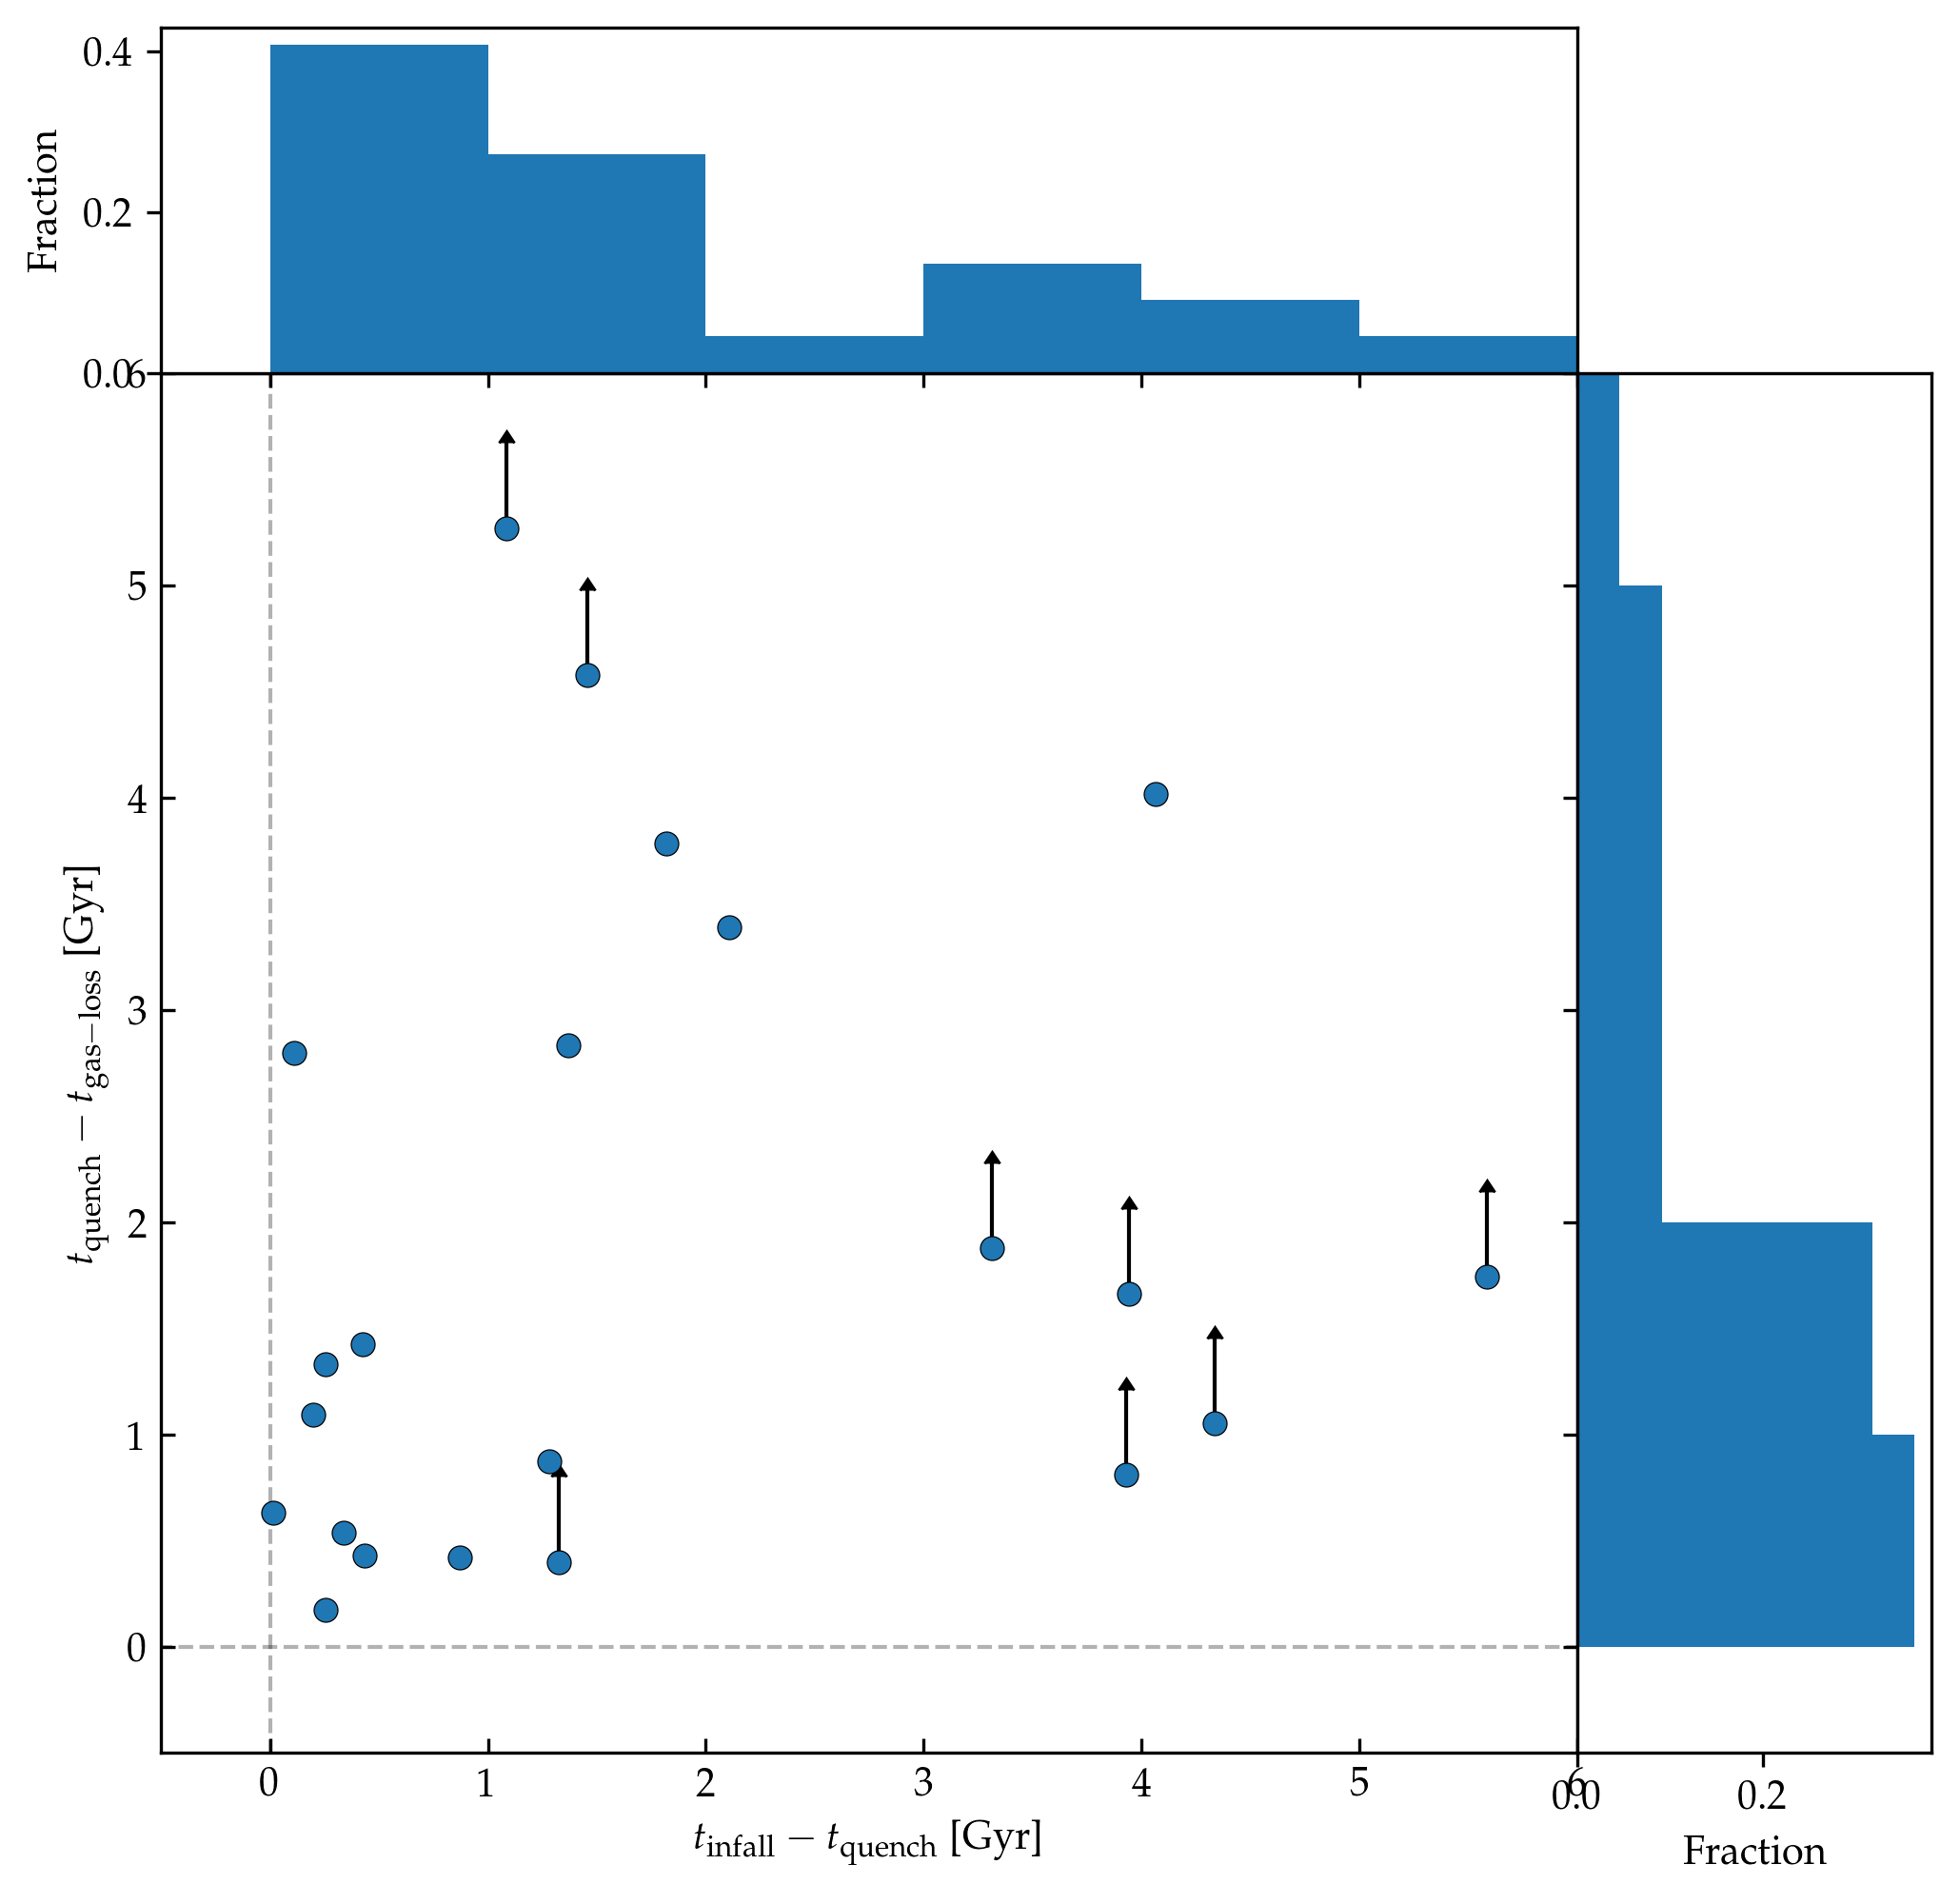

In [197]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

x = np.random.beta(2,5,size=int(1e4))
y = np.random.randn(int(1e4))

fig = plt.figure(figsize=(8,8), dpi=300)
gs = gridspec.GridSpec(5, 5)
ax_main = plt.subplot(gs[1:5, :4])
ax_xDist = plt.subplot(gs[0, :4],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:5, 4],sharey=ax_main)

data = read_data()
data = data[(data.quenched) & (~np.isnan(data.tinfall))]

f = np.array(data.tinfall-data.tquench > 0, dtype=bool)
data = data[f]

tquench = np.array(data.tquench, dtype=float)
tquench_upper_error = np.abs(np.array(data.tquench_lower, dtype=float) - tquench) # flipped intentionally
tquench_lower_error = np.abs(np.array(data.tquench_upper, dtype=float) - tquench)

tgas = np.array(data.tgasloss, dtype=float)
tgas_upper_error = np.abs(np.array(data.tgasloss_upper, dtype=float) - tgas)
tgas_lower_error = np.abs(np.array(data.tgasloss_lower, dtype=float) - tgas)

tau_upper_err = np.sqrt(tquench_upper_error**2 + tgas_upper_error**2)
tau_lower_err = np.sqrt(tquench_lower_error**2 + tgas_lower_error**2)

q = np.array(data.has_gas,dtype=bool)



x = tinfall - tquench
y = tquench - tgas


ax_main.errorbar(x[q], y[q], yerr = 0.4, elinewidth=1, 
            mew = 0.7,
            ecolor='k',
            capsize=2,
            capthick=1,
            fmt='o',
            mec = 'none',
            mfc = 'none',
            ms = 0,
            lolims=True,)

# im = ax.scatter(x, y, c=data.M_star, cmap='inferno', norm=mpl.colors.LogNorm(), linewidths=0.3, edgecolor='k', zorder=100)
# cbar = fig.colorbar(im,ax=ax)
# cbar.set_label(r'Stellar Mass [$\mathrm{M}_{\odot}$]')

ax_main.scatter(x, y, linewidths=0.3, edgecolor='k', zorder=100)


# zero lines
ax_main.plot([-1, 7], [0,0], 'k--', linewidth=1, alpha=0.3, zorder=0)
ax_main.plot([0,0], [-1, 7], 'k--', linewidth=1, alpha=0.3, zorder=0)




ax_main.set_xlim(-0.5, 6)
ax_main.set_ylim(-0.5, 6)
# ax.set_ylim(-14,3)

ax_main.set_xlabel('$t_{\mathrm{infall}}-t_{\mathrm{quench}}$ [Gyr]')
ax_main.set_ylabel('$t_{\mathrm{quench}}-t_{\mathrm{gas-loss}}$ [Gyr]')

ax_main.tick_params(direction='in',which='both')
ax_main.yaxis.set_ticks_position('both')
ax_main.xaxis.set_ticks_position('both')


bins = np.arange(0,7,1)
ax_xDist.hist(x,bins=bins, weights=np.ones(len(x))/len(x))
ax_xDist.set(ylabel='Fraction')
ax_xDist.tick_params(top=False, bottom=False, labelbottom=False, left=True, right=False)

ax_yDist.hist(y,bins=bins,orientation='horizontal', weights=np.ones(len(y))/len(y))
ax_yDist.set(xlabel='Fraction')
# ax_yDist.axis('off')
ax_yDist.tick_params(top=False, bottom=True, labelleft=False, left=False, right=False)

plt.subplots_adjust(wspace=0., hspace=0.)
plt.show()

In [ ]:
data = read_file('h148')